### Project Statement: 
### Team was approached by a law enforcement security company that would like to incorporate facial recognition and identification into their system. Company has provided the team with the umist_cropped.mat dataset to train Machine Learning system.
### Dataset has images of 20 different person. Images of each person contains different profile of face of that person. Total number of images for each person is different. 
### Goal: Using clustering techniques, incorporate facial recognition and identification of different images.

In [1]:
'''
Main steps taken:
1) Load data
2) Increase data using autoencoder to make stratified datasets
3) scaling data
4) Shuffling data in-folder(shuffling images among the one person images)
5) Create stratified train, validation, test data
6) Shuffle all 3 datasets again out-folder (shuffling across whole dataset that includes all persons images)
7) Implementing different cluster techniques
8) Training and evaluating ANN classfier model
9) Fine-tuning Hyper parameters of ANN model - RandomizedSearchCV
10) Predicting and showing the results
    
    Getting 92-95% Accuray on Test data(Unkown data)
'''

'\nMain steps taken:\n1) Load data\n2) Increase data using autoencoder to make stratified datasets\n3) scaling data\n4) Shuffling data in-folder(shuffling images among the one person images)\n5) Create stratified train, validation, test data\n6) Shuffle all 3 datasets again out-folder (shuffling across whole dataset that includes all persons images)\n7) Implementing different cluster techniques\n8) Training and evaluating ANN classfier model\n9) Fine-tuning Hyper parameters of ANN model - RandomizedSearchCV\n10) Predicting and showing the results\n    \n    Getting 92-95% Accuray on Test data(Unkown data)\n'

In [2]:
#Importing required libraries
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
#----loading and checking the data 

loaded_data = loadmat('umist_cropped.mat')
data = loaded_data['facedat']

In [4]:
#Checking shape and total number of images in each person's directory

total=0
print('Persons--img len,img width,Num of img')
print('-------------------------------------------------------')

for i in range(len(data[0])):
    print(f'person {i+1}->  {data[0][i].shape}')
    temp = data[0][i].shape[2]
    total = total+temp
    
print(f'\nTotal images of all persons in the dataset--> {total}')

Persons--img len,img width,Num of img
-------------------------------------------------------
person 1->  (112, 92, 38)
person 2->  (112, 92, 35)
person 3->  (112, 92, 26)
person 4->  (112, 92, 24)
person 5->  (112, 92, 26)
person 6->  (112, 92, 23)
person 7->  (112, 92, 19)
person 8->  (112, 92, 22)
person 9->  (112, 92, 20)
person 10->  (112, 92, 32)
person 11->  (112, 92, 34)
person 12->  (112, 92, 34)
person 13->  (112, 92, 26)
person 14->  (112, 92, 30)
person 15->  (112, 92, 19)
person 16->  (112, 92, 26)
person 17->  (112, 92, 26)
person 18->  (112, 92, 33)
person 19->  (112, 92, 48)
person 20->  (112, 92, 34)

Total images of all persons in the dataset--> 575


In [5]:
#----------------Autoencoder on every person-------#
'''
After checking the data, we found that total number of images are different for each person.
Hence, using Autoencoder we are generating new but same kind of images for the person whose
total images are less then 48 which is a maximum number of image of 19th person in the dataset.

So that, at the end, each person will have 48 images and total number of images will be 
increased to 48*20 = 960
'''

'\nAfter checking the data, we found that total number of images are different for each person.\nHence, using Autoencoder we are generating new but same kind of images for the person whose\ntotal images are less then 48 which is a maximum number of image of 19th person in the dataset.\n\nSo that, at the end, each person will have 48 images and total number of images will be \nincreased to 48*20 = 960\n'

In [6]:

#Created 2-D empty array, so that we can append images to this array; that contains pixels of each image in the row
#Also, these pixels are scaled, hence value would be normalized between 0 to 1.
#Furthermore, this array will contain original images and new images generated by autoencoder where needed to finally create 
#array with 960 images that means 960 rows.

data_array = np.empty((1,10304))

In [7]:
#Auto-encoder below is generating new images

for i in range(20):
    
    per = data[0][i]
    per = per/255  #Scaling
    
    total_img_per = per.shape[2] #Taking total number of images of each person
    
    #Flatten data
    temp = per.reshape(10304,total_img_per)
    per_flat = temp.T
    
    
    encoding_dim = 64 # bottleneck of autoencoder. Set to 64 nodes
    
    #Encoder
    # This is our input image
    input_img = keras.Input(shape=(10304,))
    encoded = layers.Dense(300, activation='relu')(input_img)
    encoded = layers.Dense(100, activation='relu')(encoded)
        
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)    #Bottleneck layer
        
    #Decoder
    decoded = layers.Dense(100, activation='relu')(encoded)
        
    decoded = layers.Dense(300, activation='relu')(decoded)
    decoded = layers.Dense(10304, activation='sigmoid')(decoded)
   
    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_img, decoded)
        
        
        
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                                    loss='binary_crossentropy')
        
        
        
    autoencoder.fit(per_flat, per_flat,
                            epochs=20,
                            batch_size= 16,
                            shuffle=True
                            )
        
    data_concat = np.empty((1, 10304))
    while total_img_per<48:
        per_enc = autoencoder.predict(per_flat)
            
        data_concat = np.concatenate((data_concat, per_enc), axis=0)
            
        total_img_per += per_enc.shape[0]
        print(total_img_per)
        
    data_concat = data_concat[1:,:]
        
    data_array = np.concatenate((data_array, per_flat), axis=0)
    data_array = np.concatenate((data_array, data_concat[:48-per_flat.shape[0],:]), axis=0)
        
data_array = data_array[1:,:]    

Epoch 1/20
3/3 [==============================] - 1s 98ms/step - loss: 0.6976
Epoch 2/20
3/3 [==============================] - 0s 81ms/step - loss: 0.7002
Epoch 3/20
3/3 [==============================] - 0s 87ms/step - loss: 0.6645
Epoch 4/20
3/3 [==============================] - 0s 59ms/step - loss: 0.6766
Epoch 5/20
3/3 [==============================] - 0s 85ms/step - loss: 0.6642
Epoch 6/20
3/3 [==============================] - 0s 76ms/step - loss: 0.6513
Epoch 7/20
3/3 [==============================] - 0s 106ms/step - loss: 0.6467
Epoch 8/20
3/3 [==============================] - 0s 79ms/step - loss: 0.6271
Epoch 9/20
3/3 [==============================] - 0s 87ms/step - loss: 0.6206
Epoch 10/20
3/3 [==============================] - 0s 93ms/step - loss: 0.6178
Epoch 11/20
3/3 [==============================] - 0s 109ms/step - loss: 0.6173
Epoch 12/20
3/3 [==============================] - 0s 90ms/step - loss: 0.6140
Epoch 13/20
3/3 [==============================] - 0s 87ms/

In [8]:
#shape of the new array 960X 10304 where 960 rows are for 960 images
#10304 is flattened features converted from 112 X 92 = 10304 dimension

print(data_array.shape)

(960, 10304)


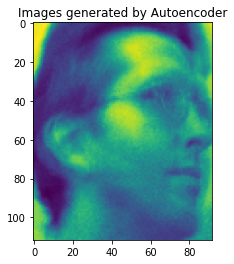

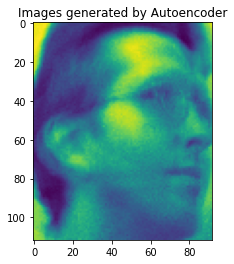

In [9]:
for i in range(94,96):
    plt.imshow(data_array[i:i+1,:].reshape((112,92)))
    plt.title('Images generated by Autoencoder')
    plt.show()

In [10]:
#-------Creating training, validation and testing dataset--------#
'''
As we have same total number of images(48 images each) for all 20 persons in the dataset,
we can create stratified training , validation and testing data

We are taking 30 images of each person for trainig data. Hence total images for training is 30X20 = 600

From remaining images, we are diviing images into 50% - 50% for validation and test data
Hence, we are taking 9 images of each person for validation and testing data both
Thus, validation data and test data will have 9X20 = 180 images total in both set.
'''

'\nAs we have same total number of images(48 images each) for all 20 persons in the dataset,\nwe can create stratified training , validation and testing data\n\nWe are taking 30 images of each person for trainig data. Hence total images for training is 30X20 = 600\n\nFrom remaining images, we are diviing images into 50% - 50% for validation and test data\nHence, we are taking 9 images of each person for validation and testing data both\nThus, validation data and test data will have 9X20 = 180 images total in both set.\n'

In [11]:
train_data = np.empty((1, 10304))
val_data = np.empty((1, 10304))
test_data = np.empty((1, 10304))

start = 0 
end = 48

while end < 961:
    main_data = data_array[start:end, :]
    main_data = np.take(main_data ,np.random.permutation(main_data.shape[0]),axis=0,out=main_data)

    
    train_data = np.concatenate((train_data,main_data[:30,:]), axis=0)
    val_data = np.concatenate((val_data,main_data[30:39,:]), axis=0)
    test_data = np.concatenate((test_data,main_data[39:48,:]), axis=0)
    
    start += 48
    end += 48
    
train_data = train_data[1:,:]
val_data = val_data[1:,:]
test_data = test_data[1:,:]

In [12]:
print(f'Shape of training dataset: {train_data.shape}')
print(f'Shape of validation dataset: {val_data.shape}')
print(f'Shape of test dataset: {test_data.shape}')

Shape of training dataset: (600, 10304)
Shape of validation dataset: (180, 10304)
Shape of test dataset: (180, 10304)


In [13]:
#------Shuffling training , validation and testing dataset----------#

'''
In above section, we created train ,validation and test data
But, it contains images in order starting from person 1 to person 20
With this kind of dataset, our model or cluster technique won't be able to perform well.
Hence, we need to shuffle all 3 datasets
'''

train_shuff = np.take(train_data ,np.random.permutation(train_data.shape[0]),axis=0,out=train_data)
val_shuff = np.take(val_data ,np.random.permutation(val_data.shape[0]),axis=0,out=val_data)
test_shuff = np.take(test_data ,np.random.permutation(test_data.shape[0]),axis=0,out=test_data)


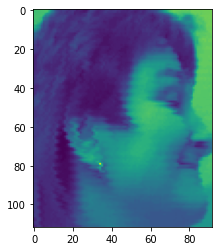

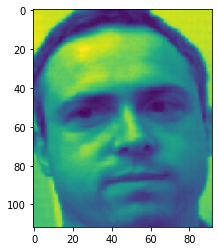

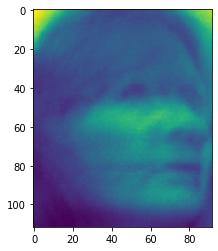

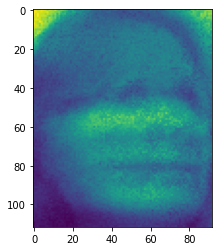

In [14]:
#---- Visualzing images after processing---#

'''
After performing number of processing steps on dataset, let's check few images
from the newly created datasets
'''

for i in range(41,45):
    plt.imshow(train_shuff[i:i+1,:].reshape((112,92)))
    plt.show()

In [15]:
#--------Dimensionality reduction--------#

'''
Dimension of all images is = (112,92)
We have flatten this dimensions and saved all the pixels of each image in row 
Therefore, we have total 10304 features.

We can reduce features using PCA (Principle Component Analysis) technique
By keeping 99% of variance we will reduce dimensions of all 3 datasets

'''

'\nDimension of all images is = (112,92)\nWe have flatten this dimensions and saved all the pixels of each image in row \nTherefore, we have total 10304 features.\n\nWe can reduce features using PCA (Principle Component Analysis) technique\nBy keeping 99% of variance we will reduce dimensions of all 3 datasets\n\n'

In [16]:
from sklearn.decomposition import PCA
pca = PCA(0.99) # create a PCA object that ensures 99% variance

pca.fit(train_shuff)
train_pca = pca.transform(train_shuff) # get PCA coordinates for scaled trainig data

In [17]:
#Also, to visualize 2D graphs we are saving only first 2 Priniciple Component to 'train_pca2' variable
#But, we will train_pca2 only for 2D visualization. Other than that, we will use 'train_pca' variable that contains 99% variance.

train_pca2 = train_pca[:,0:2]

In [18]:
#--PCA on validation set
val_pca = pca.transform(val_shuff)

#--PCA on test set
test_pca = pca.transform(test_shuff)

In [19]:
print(f'\nDimension of training data after reducing dimension --> {train_pca.shape}')
print(f'Dimension of validation data after reducing dimension --> {val_pca.shape}')
print(f'Dimension of testing data after reducing dimension --> {test_pca.shape}')

print('\nAfter applying PCA to dataset, dimensions are reduced from 10304 to 206 ')


Dimension of training data after reducing dimension --> (600, 213)
Dimension of validation data after reducing dimension --> (180, 213)
Dimension of testing data after reducing dimension --> (180, 213)

After applying PCA to dataset, dimensions are reduced from 10304 to 206 


In [20]:
#------Using different Clustering Techniques to generate clusters------#
'''
We have tried 3 clustering Techniques
1) AHC - agglomerative hierarchical clustering
2) K-means clustering
3) GMM - Gaussian Mixture Model

As this project has Unsupervised problem, we got train, validation and test data from given data
But, we dont have Acutal labels connected to it.

Using clustering technique, we will try to segregrate all datasets into clusters where each cluster
contains same(similar) images.

We will assume that each cluster contains images of same person and we will attach same label to all the images in the same cluster.
And, this is how we will get Actual labels for all 3 dataset with which we can use any Supervised learning classifier to train the model and 
give predictions
'''

'\nWe have tried 3 clustering Techniques\n1) AHC - agglomerative hierarchical clustering\n2) K-means clustering\n3) GMM - Gaussian Mixture Model\n\nAs this project has Unsupervised problem, we got train, validation and test data from given data\nBut, we dont have Acutal labels connected to it.\n\nUsing clustering technique, we will try to segregrate all datasets into clusters where each cluster\ncontains same(similar) images.\n\nWe will assume that each cluster contains images of same person and we will attach same label to all the images in the same cluster.\nAnd, this is how we will get Actual labels for all 3 dataset with which we can use any Supervised learning classifier to train the model and \ngive predictions\n'

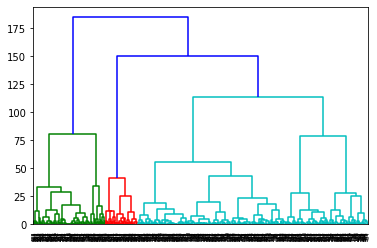

In [21]:

#--------------------------#
#------Using AHC on PCA trainig data to and visualize and select number of clusters
#--------------------------#
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


#Creating dendogram to check correct number of clusters
dnd = sch.dendrogram(sch.linkage(train_pca2, method='ward'))

In [22]:
# Initialize hiererchial clustering method, in order for the algorithm to determine the number of clusters
# putting n_clusters=None, compute_full_tree = True,
# best distance threshold value for this dataset is distance_threshold = 51

cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', compute_full_tree=True, 
                                  distance_threshold=51)

In [23]:
# Cluster the data
cluster.fit_predict(train_pca)

print(f"Number of clusters = {1+np.amax(cluster.labels_)}")
AHC_labels = cluster.labels_

Number of clusters = 19


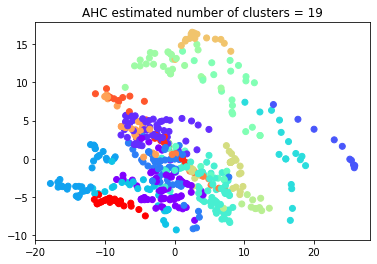

In [24]:
#Plotting
plt.scatter(train_pca2[:,0],train_pca2[:,1], c=cluster.labels_, cmap='rainbow')
plt.title(f"AHC estimated number of clusters = {1+np.amax(cluster.labels_)}")
plt.show()

In [25]:
#Above, we tried to affinity = euclidean, Manhattan, cosine 
#And, tried linkage = ward, complete, single, average
#However, combination of 'euclidean' and 'ward' seems to be giving best seggregation of clusters

In [26]:
#-------------------Kmeans clustering-------------#
'''
K-means clustering does hard clustering
It tends to create rounded shaped cluster and tries to keep cluster sizes same
It works on cluster centers. Hence it is a center based clustering technique
Also, it is a top-down clustering technique
'''

'\nK-means clustering does hard clustering\nIt tends to create rounded shaped cluster and tries to keep cluster sizes same\nIt works on cluster centers. Hence it is a center based clustering technique\nAlso, it is a top-down clustering technique\n'

Text(0, 0.5, 'Inertia')

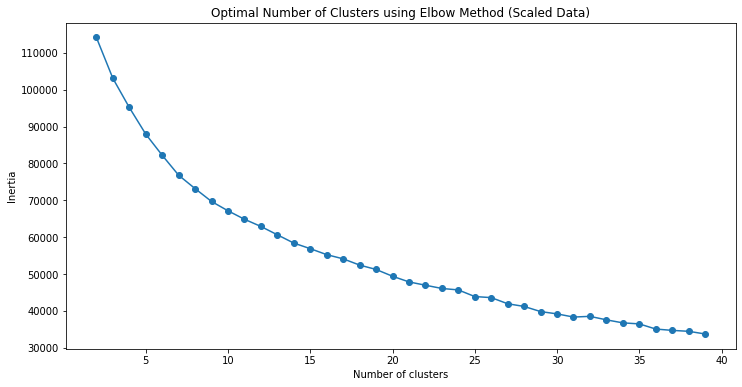

In [27]:
#Using Elbow method for kmean clustering to decide number of clusters
from sklearn.cluster import KMeans


#Choosing K-value for k-mean cluster - using origina features
sse = []
k_list = range(2, 40)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(train_pca)
    sse.append([k, km.inertia_])

#Creating a line graph to select best k-value
oca_results_scale = pd.DataFrame({'Cluster': range(2,40), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

KMeans Scaled Silhouette Score: 0.2530882058254982


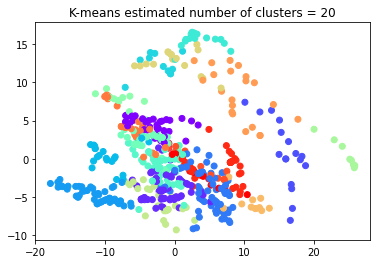

In [28]:
#Selected k-value =20

kmeans_scale = KMeans(n_clusters=20, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(train_pca)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(train_pca, kmeans_scale.labels_, metric='euclidean')))
 
labels_scale = kmeans_scale.labels_


plt.scatter(train_pca2[:,0],train_pca2[:,1], c=kmeans_scale.labels_, cmap='rainbow')
plt.title(f"K-means estimated number of clusters = {1+np.amax(kmeans_scale.labels_)}")
plt.show()

In [29]:
#--------Gaussian Mixture Model---------#
'''
GMM creates clusters on the basis of Gaussian Mixture.
Hence, it add data point to the cluster on the basis of mean and variance of the Gaussian Mixture
It can do both soft and hard clustering.
It is more flexible than K-means clustering
'''

'\nGMM creates clusters on the basis of Gaussian Mixture.\nHence, it add data point to the cluster on the basis of mean and variance of the Gaussian Mixture\nIt can do both soft and hard clustering.\nIt is more flexible than K-means clustering\n'

In [30]:
from sklearn.mixture import GaussianMixture


gmm_vis = GaussianMixture(20, covariance_type='full', random_state=0)
gmm_vis.fit(train_pca2)

GaussianMixture(n_components=20, random_state=0)

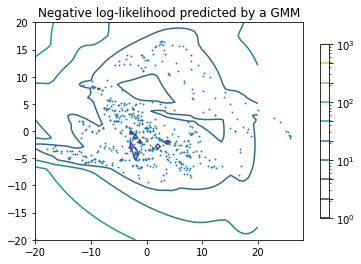

In [31]:
from matplotlib.colors import LogNorm

# display predicted scores by the model as a contour plot
x = np.linspace(-20.0, 20.0)
y = np.linspace(-20.0, 20.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_vis.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(train_pca2[:, 0], train_pca2[:, 1], 0.8)

plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()

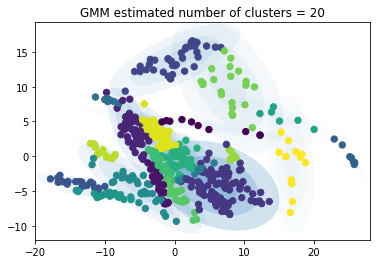

In [32]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
        
    ax.axis('equal')
    plt.title('GMM estimated number of clusters = 20')    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)



plot_gmm(gmm_vis, train_pca2)

In [33]:
#Checked GMM model with different 'Covariance_type' = full, tied, diag, spherical
#Found that 'full' was giving best results because it was giving less skewed labels and 
#it was giving more accuracy at the end on test data


'''
Selected Gaussian Mixture Model as a clustering Technique for this problem
Reasons:
1) By analyzing graph, it seems that many data are scatter on ellipsodial shape.
    GMM works better when clusters shape are ellipsoial because it used gaussian mixture and covariance rather than 
    only depending on center of cluster

2) As it was generating less skewed data and it was generating as much as same number of labels for each person.
    We are looking for same number of labels for each person because we already know that same number of images are present 
    in trainig data.
    
3) By running classifier in following section; using labels generated by all clustering technique we found that 
    classifier was giving bit high accuracy consistantly when we used labls generated by GMM.

'''

#Therefore, we are generating labels using GMM for all 3 datasets
#Labels generated by GMM will act as actual labels for correspnding features dataset
#And, we will be able to train supervised learning model on the basis of training data that we created above 
#and correspnding actual labels that are generated below by GMM technique

'\nSelected Gaussian Mixture Model as a clustering Technique for this problem\nReasons:\n1) By analyzing graph, it seems that many data are scatter on ellipsodial shape.\n    GMM works better when clusters shape are ellipsoial because it used gaussian mixture and covariance rather than \n    only depending on center of cluster\n\n2) As it was generating less skewed data and it was generating as much as same number of labels for each person.\n    We are looking for same number of labels for each person because we already know that same number of images are present \n    in trainig data.\n    \n3) By running classifier in following section; using labels generated by all clustering technique we found that \n    classifier was giving bit high accuracy consistantly when we used labls generated by GMM.\n\n'

In [34]:
#Fitting on train_pca  
gmm = GaussianMixture(20, covariance_type='full', random_state=2)
gmm.fit(train_pca)

#--Creating trainig Actual labels
train_labels = gmm.predict(train_pca)

#---Creating validation Acutal labels
val_labels= gmm.predict(val_pca)

#--Creating testing Actual labels
test_labels= gmm.predict(test_pca)

In [35]:
#------ANN(Artificial Neural Network)--------#

'''
As we have trainig features in 'train_pca' and its actual labels in 'test_labels' variable
We can train ANN model to make predictions
'''

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [36]:
'''
Input layer contains total nodes equal to toal number of features(columns) in training data
Out Layer contains total nodes equal to toal number of class we have in labels

Total number of hidden layers = 2
Total Nodes in the hidden layers respectively = 1000, 500

Activation function in hidden layer = LeakyRelu
Activation function in output layer = Softmax

'''

'\nInput layer contains total nodes equal to toal number of features(columns) in training data\nOut Layer contains total nodes equal to toal number of class we have in labels\n\nTotal number of hidden layers = 2\nTotal Nodes in the hidden layers respectively = 1000, 500\n\nActivation function in hidden layer = LeakyRelu\nActivation function in output layer = Softmax\n\n'

In [37]:
ann = models.Sequential([
    keras.Input(shape=(train_pca.shape[1],)),
    layers.Dense(2000, activation=keras.layers.LeakyReLU(alpha=0.01)),
    layers.Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.01)),
    layers.Dense(20, activation='softmax')
    ])

In [38]:
'''
Used loss function 'sparse_categorical_crossentropy' because we have multiclass classification problem.
Hence we can not use 'binary_crossentropy' as loss function

Tried optimizer adam and SGD. But 'adam' given high accuracy than SGD
'''
ann.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [39]:
ann.fit(train_pca, train_labels, epochs=10, validation_data = (val_pca,val_labels))

Epoch 1/10
19/19 [==============================] - 1s 35ms/step - loss: 0.7347 - accuracy: 0.7817 - val_loss: 0.2543 - val_accuracy: 0.9278
Epoch 2/10
19/19 [==============================] - 1s 28ms/step - loss: 0.0959 - accuracy: 0.9617 - val_loss: 0.3583 - val_accuracy: 0.9056
Epoch 3/10
19/19 [==============================] - 1s 28ms/step - loss: 0.0662 - accuracy: 0.9783 - val_loss: 0.3132 - val_accuracy: 0.9222
Epoch 4/10
19/19 [==============================] - 1s 27ms/step - loss: 0.0851 - accuracy: 0.9800 - val_loss: 0.3369 - val_accuracy: 0.9444
Epoch 5/10
19/19 [==============================] - 1s 28ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.2160 - val_accuracy: 0.9389
Epoch 6/10
19/19 [==============================] - 1s 26ms/step - loss: 0.0178 - accuracy: 0.9950 - val_loss: 0.2073 - val_accuracy: 0.9556
Epoch 7/10
19/19 [==============================] - 1s 27ms/step - loss: 0.0163 - accuracy: 0.9967 - val_loss: 0.3087 - val_accuracy: 0.9389
Epoch 8/10
19

In [40]:
ann.evaluate(test_pca, test_labels)

6/6 [==============================] - 0s 9ms/step - loss: 0.2653 - accuracy: 0.9500


[0.2652580738067627, 0.949999988079071]

In [41]:
#Predicting on Test data(unkown data)
y_pred = ann.predict(test_pca)

for i in range(y_pred.shape[0]):
    y_pred[i] = y_pred[i].argmax()
    
y_pred = y_pred[:,:1]
    
#Accuracy
accuracy_score(y_pred,test_labels )

0.95

In [42]:
from sklearn.metrics import precision_score, recall_score

In [43]:
pre = precision_score(y_pred, test_labels,average='weighted')
rec = recall_score(y_pred, test_labels,average='weighted')

print('Precision:', pre)
print('Recall:', rec)

Precision: 0.9525423127783809
Recall: 0.95


In [44]:
'''
Fine- tuning the hyper parameters to select best model with best parameter
'''
# Created function that helps to finetune 3 hyperparameters
# Number of hidden layers
# Number of neurons in hidden layers
# Value of learning rate

'\nFine- tuning the hyper parameters to select best model with best parameter\n'

In [45]:
def build_model(n_hidden=1, n_neurons=1000, opt='adam'):
    
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(train_pca.shape[1],)))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=keras.layers.LeakyReLU(alpha=0.01)))
    
    model.add(keras.layers.Dense(20,activation='softmax'))
    optimizer = opt
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [46]:
#Created dictionary that contain different value of hyper-parameter from which we want to find best using fine-tuning

param_distribs = {
"n_hidden": [2,3],
"n_neurons": [500,1000],
"opt": ['adam', 'sgd'],
}


In [47]:
#Created object of KerasClassifier so that we can use randomizedSearchCV to fine-tune on Keras object

keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model,epochs=5,batch_size=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
#Created object of RandomizedSearchCV
np.random.seed(42)
rscv = RandomizedSearchCV(estimator= keras_reg, param_distributions=param_distribs, cv=3,  n_iter=5)

#Fitted training data to train model
rscv_results = rscv.fit(train_pca,train_labels, validation_data=(val_pca,val_labels))


Epoch 1/5
25/25 [==============================] - 1s 11ms/step - loss: 2.4111 - accuracy: 0.3800 - val_loss: 1.7777 - val_accuracy: 0.6278
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 1.4237 - accuracy: 0.7725 - val_loss: 1.1722 - val_accuracy: 0.8278
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 0.9215 - accuracy: 0.8925 - val_loss: 0.8327 - val_accuracy: 0.8722
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.6364 - accuracy: 0.9125 - val_loss: 0.6426 - val_accuracy: 0.8778
Epoch 5/5
13/13 [==============================] - 0s 2ms/step - loss: 0.6370 - accuracy: 0.8800
Epoch 1/5
25/25 [==============================] - 1s 12ms/step - loss: 2.4301 - accuracy: 0.3925 - val_loss: 1.8206 - val_accuracy: 0.6333
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 1.5106 - accuracy: 0.7550 - val_loss: 1.2144 - val_accuracy: 0.8111
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - lo

In [49]:
#Best paramters after fine-tuning model
rscv.best_params_

{'n_hidden': 2, 'n_neurons': 500, 'opt': 'adam'}

In [50]:
#Predicted test data
y_pred = rscv.predict(test_pca)

In [51]:
accuracy_score(y_pred, test_labels)


0.9555555555555556

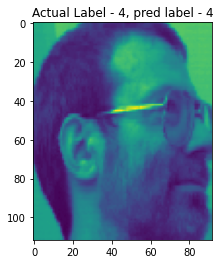

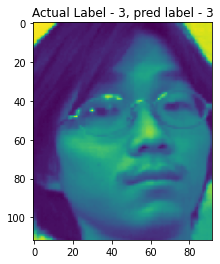

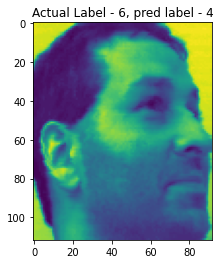

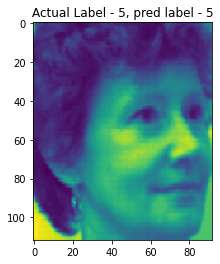

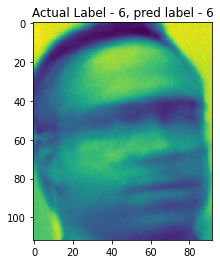

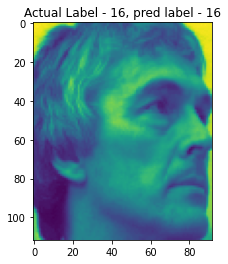

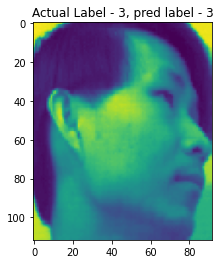

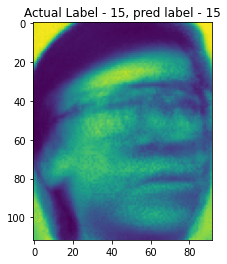

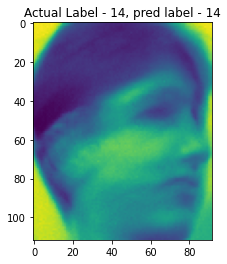

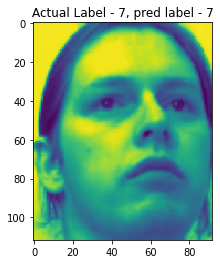

In [52]:
#Plotting images 
#Their titles contains actual labels and predicts results
for i in range(110,120):
    plt.imshow(test_shuff[i:i+1,:].reshape((112,92)))
    plt.title(f'Actual Label - {test_labels[i]}, pred label - {y_pred[i]}')
    plt.show()